# Bell State 

To illustrate a multi qubit application of quantum gates, we will create a Bell state. A Bell state is a two qubit state that is maximally entangled.

In [1]:
import sys

sys.path.append("..")

In [2]:
from qiskit.primitives import Sampler
from qiskit.visualization import plot_histogram
import numpy as np
import plotly.express as px
from sklearn.pipeline import make_pipeline

from skq.gates import *
from skq.utils import to_bitstring
from skq.circuits import BellStates
from skq.quantum_info import PhiPlusState
from skq.transformers import MeasurementTransformer
from skq.converters import pipeline_to_qiskit_circuit

In [3]:
pipe = make_pipeline(BellStates().get_bell_state(configuration=1), MeasurementTransformer(repeat=1000))

The quantum union will combine the Hadamard and the Identity matrix through a Kronecker product.

In [4]:
pipe

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('H',
                                  QuantumLayer(n_qubits=2,
                                               transformer_list=[('H',
                                                                  HTransformer(qubits=[0]))])),
                                 ('CNOT', CXTransformer(qubits=[0, 1]))])),
                ('measurementtransformer',
                 MeasurementTransformer(repeat=1000))])

In [5]:
# |00> qubits
X = np.array([[1, 0, 0, 0]], dtype=complex)

The 2 steps will create the bell state.

$$\frac{1}{\sqrt{2}}(|00\rangle + |11\rangle)$$

The 3rd step will measure the qubits to verify the state. This will result in 00 or 11 with equal probability.

In [6]:
hadamard = pipe[0].transform(X)
hadamard

array([[0.70710678+0.j, 0.        +0.j, 0.        +0.j, 0.70710678+0.j]])

In [7]:
bell_state = pipe[:-1].transform(X)
bell_state

array([[0.70710678+0.j, 0.        +0.j, 0.        +0.j, 0.70710678+0.j]])

In [8]:
measurements = pipe.transform(X)

In [9]:
print(measurements.shape)
measurements[:5]

(1000, 2)


array([[0, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0]])

In [10]:
# Convert measurements to a string representation for plotting
measurement_strings = to_bitstring(measurements)
measurement_strings[:5]

['00', '00', '11', '00', '00']

In [11]:
# Plot the results using Plotly
fig = px.histogram(measurement_strings, x=measurement_strings, title="Measurement Results of Bell State", labels={"x": "Measurement Outcome", "y": "Count"}, text_auto=True)
fig.show()

For convenience we can also directly get the Bell State as a StateVector.

In [12]:
phi_plus = PhiPlusState()
phi_plus

PhiPlusState([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
              0.70710678+0.j])

In [13]:
measurements = [phi_plus.measure_bitstring() for _ in range(1000)]
px.histogram(measurements)

# Interoperability with other frameworks (Qiskit, PennyLane, etc.)

Lots of `skq` objects can be converted to Qiskit and PennyLane. This includes state vectors, density matrices, gates and pipelines.

In [14]:
phi_plus.to_qiskit()

Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.70710678+0.j],
            dims=(2, 2))


In [15]:
phi_plus.to_pennylane()

QubitStateVector(PhiPlusState([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
              0.70710678+0.j]), wires=[0, 1])

In [16]:
pipe

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('H',
                                  QuantumLayer(n_qubits=2,
                                               transformer_list=[('H',
                                                                  HTransformer(qubits=[0]))])),
                                 ('CNOT', CXTransformer(qubits=[0, 1]))])),
                ('measurementtransformer',
                 MeasurementTransformer(repeat=1000))])

In [17]:
qiskit_circuit = pipeline_to_qiskit_circuit(pipe, 2)

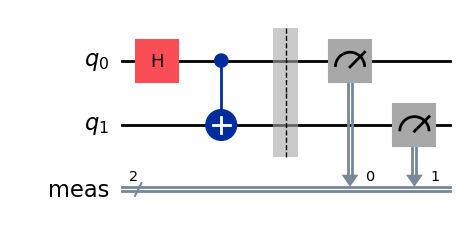

In [18]:
qiskit_circuit.draw("mpl")

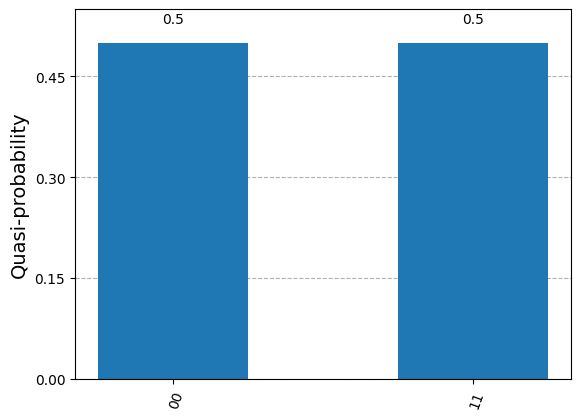

In [19]:
# Run the circuit using the Qiskit Sample
results = Sampler().run(qiskit_circuit).result()
statistics = results.quasi_dists[0].binary_probabilities()
display(plot_histogram(statistics))